In [1]:

# ref https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52

In [114]:
from __future__ import print_function
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib
## This is for backend, gui support, but it doesnt do anything ##
matplotlib.use('TkAgg') 
from matplotlib import figure
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from datetime import datetime
import re
from tqdm.auto import tqdm, trange
import time

# See least_common_values function below
from operator import itemgetter
import heapq 

import collections
import sys
from pathlib import Path
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix



import seaborn as sns
import hdbscan


In [115]:
##### Rename RiskFactors > Data > Run  <for f in *\ *; do mv "$f" "${f// /_}"; done> in bash, in Data ####
##### This changes all " " characters to "_", needed for Path######
##### See https://stackoverflow.com/a/18213120 #####


NUMBER_OF_DOCS = 10
doclist = []
global names
names = []
pathlist = Path("Data_Small").glob('**/*.txt')
pathlist = Path("Data").glob('**/*.txt')
for path in tqdm(pathlist):
    # because path is object not string
    path_in_str = str(path)
    name = path_in_str.split("\\")[1].split(".")[0]
    names.append(name.replace("_", " "))
    #TODO SPLIT PATH TO COMPANY NAME, make Index
    file = open(path, "r") 
    # print "Output of Readlines after appending"
    text = file.readlines()
#     print(text[:10])
    doclist.append(text[0].replace(name, "<NAME>"))
if len(doclist) > NUMBER_OF_DOCS:
    doclist = doclist[:NUMBER_OF_DOCS]
    names = names[:NUMBER_OF_DOCS]
    
# company_dataframe = pd.DataFrame({'text':doclist, 'names': names })

In [116]:
print('%s docs loaded'% len(names))
print()
print(names[:10], '......',  names[-10:])


10 docs loaded

['180 Degree Capital Corp ', '1 800 FLOWERS COM Inc ', '2U Inc ', '3D Systems Corporation', '3M Company', 'A10 Networks Inc ', 'AAC Holdings Inc ', 'AAON Inc ', 'AAR Corp ', 'Abbott Laboratories'] ...... ['180 Degree Capital Corp ', '1 800 FLOWERS COM Inc ', '2U Inc ', '3D Systems Corporation', '3M Company', 'A10 Networks Inc ', 'AAC Holdings Inc ', 'AAON Inc ', 'AAR Corp ', 'Abbott Laboratories']


In [246]:
def get_tokens(doclist):
    token_list = []
    for doc in tqdm(doclist, desc="Tokenizing",leave=False):
        dirty_tokens = nltk.sent_tokenize(doc)
#         dirty_tokens = nltk.word_tokenize(doc)
        token_list += [dirty_tokens]
    return token_list

In [247]:
def get_filtered(token_list, doclist):
    punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
    more_stops = ['\\t\\t\\t', 
        '\\t\\t\\', '\\t\\t\\t',
        '<U+25CF>', '[1]']
    maybe_bad_stops = ['may', 'could',  'contents', 'table', 'time', '25cf', 'factors', 'risk']
    global Stopwords_list 
    Stopwords_list= stopwords.words('english') + more_stops + punc + maybe_bad_stops
    filtered_tokens = []
    if len(token_list) != len(doclist):
        token_list = [token_list]
    index = 0
    names_list=[]
    for tokens in tqdm(token_list, desc="Filtering Documents"):
        filtered_docs = []
        name = names[index]
        for token in tqdm(tokens, desc="Filtering Words", leave=False):
            if re.search(r'\d{1,}', token): #getting rid of digits
                pass
            else:
#                 NNP proper noun, singular ‘Harrison’
#                 NNPS proper noun, plural ‘Americans’
                if token not in Stopwords_list and pos_tag(token) != 'NNP' and pos_tag(token) != 'NNPS':
                    filtered_docs.append(token.lower())
                    names_list.append(name)
        index += 1
        filtered_tokens.append(filtered_docs)        
    return filtered_tokens, names_list

In [248]:
def do_stemming(filtered_tokens):
    stemmed = []
    names_list = []
    index = 0
    for doc in filtered_tokens:
        name = names[index]
        index += 1
        for f in tqdm(doc, desc="Stemming", leave=False):
            names_list.append(name)

            stemmed.append(PorterStemmer().stem(f))
            #stemmed.append(LancasterStemmer().stem(f))
            #stemmed.append(SnowballStemmer('english').stem(f))
    stemmed_dict = {'stems': stemmed, 'names': names_list}
    return stemmed, stemmed_dict

In [249]:
def vectorize_text(stemmed, smallest_ngram, largest_ngram):

    vectorizer = TfidfVectorizer(stop_words=Stopwords_list,
                                 ngram_range=((smallest_ngram, largest_ngram)))
    vectorizer = CountVectorizer(stop_words=Stopwords_list, 
                                 ngram_range=(smallest_ngram, largest_ngram), max_df=0.75, min_df=0.01)
    sparseMatrix = vectorizer.fit_transform(stemmed)
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform
    return sparseMatrix, vectorizer  

In [250]:
tokens = get_tokens(doclist)
filtered_tokens, names_list = get_filtered(tokens, doclist)
stemmed, stemmed_dict = do_stemming(filtered_tokens)

AttributeError: 'list' object has no attribute 'words'

In [121]:
largest_ngram = 15
smallest_ngram = 1
smallest_ngram = len(min(tokens[0], key=len))
largest_ngram =  len(max(tokens[0], key=len))


%time sparseMatrix, vectorizer = vectorize_text(stemmed, smallest_ngram, largest_ngram)

Wall time: 1.68 s


In [122]:
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=None, min_df=0.01,
        ngram_range=(3, 933), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...)', '[', ']', '{', '}', '%', 'may', 'could', 'contents', 'table', 'time', '25cf', 'factors', 'risk'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [123]:
sparseMatrix
# With this, each column in the matrix represents a word in the vocabulary
# each row represents the document in our dataset 
# where the values in this case are the word counts or Doc Freq if we are using tfidf vectorizer

<2327x19 sparse matrix of type '<class 'numpy.int64'>'
	with 681 stored elements in Compressed Sparse Row format>

In [124]:
%matplotlib inline

# This doesnt really work when passing many documents > 100?
# https://stackoverflow.com/questions/22961541/python-matplotlib-plot-sparse-matrix-pattern

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure(figsize=(25, 10))
    ax = fig.add_subplot(111, facecolor ='black')
    ax.plot(m.col, m.row, 's', color='white', ms=3)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [147]:
plot_coo_matrix(sparseMatrix).figure.show()


C:\Users\xanen\Anaconda3\envs\Tensor\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


In [185]:
# truek = PLEASE_FIND_ME
def cluster_it(sparseMatrix, vectorizer):
    truek = 35
    model = KMeans(n_clusters=truek, init='k-means++',
                   max_iter=20000, n_init=100, random_state=42)
    model.fit(sparseMatrix)
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    
    hdb = hdbscan.HDBSCAN(min_cluster_size=5,  gen_min_span_tree=True, generate_)
    hdb_pred = hdb.fit(sparseMatrix)
    
    return terms, order_centroids, model, truek, hdb_pred

In [206]:
##THIS TAKES ~~ 1m per 100 documents
 %time terms, order_centroids, model, truek, hdb_pred = cluster_it(sparseMatrix, vectorizer)

C:\Users\xanen\Anaconda3\envs\Tensor\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (34) found smaller than n_clusters (35). Possibly due to duplicate points in X.
  return_n_iter=True)


Wall time: 3.97 s


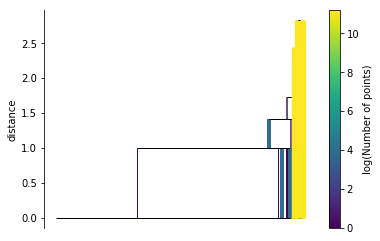

In [215]:
# hdb_labels = hdb_pred.labels_
# hdb_prediction = hdb_pred.generate_prediction_data()
# hdbscan.prediction.approximate_predict(hdb_prediction, vectorizer.transform(["string"]))
hdbscan.robust_single_linkage_.RobustSingleLinkage().fit(sparseMatrix).cluster_hierarchy_.plot()

In [216]:
hdbscan.plots.MinimumSpanningTree(mst, data)

NameError: name 'mst' is not defined

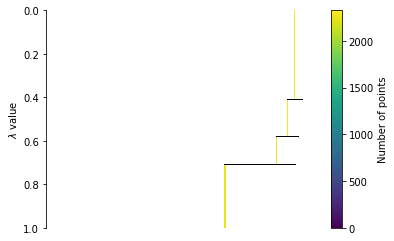

In [150]:
hdb_pred.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())


In [159]:
hdb_pred?

In [155]:
# using joblib to pickle model
model_time = datetime.now().strftime("%b%d-%I%M%p")
from sklearn.externals import joblib
joblib.dump(model, f'outputs/s2s{model_time}.pkl')
model = joblib.load(f'outputs/s2s{model_time}.pkl')


In [95]:
clusters = model.labels_.tolist()

In [96]:
len(names_list) == len(clusters)

True

In [97]:
stem_df = pd.DataFrame({'stems': stemmed, "Count":0})
stem_df = stem_df.groupby('stems').count()
stem_df.describe()

,Count
count,2219.000000
mean,1.048671
std,1.472125
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,58.000000


In [98]:
cluster_df = pd.DataFrame({'company': names_list, "label":clusters})

cluster_df.head(10)

,company,label
0,180 Degree Capital Corp,0
1,180 Degree Capital Corp,0
2,180 Degree Capital Corp,0
3,180 Degree Capital Corp,0
4,180 Degree Capital Corp,0
5,180 Degree Capital Corp,2
6,180 Degree Capital Corp,9
7,180 Degree Capital Corp,0
8,180 Degree Capital Corp,0
9,180 Degree Capital Corp,0


In [99]:
len(terms)
len(terms) == len(names_list)

False

In [100]:
nclosest_words_to_show = 10
for i in range(truek):
 print('Cluster %d:' % i),
 for ind in order_centroids[i, :nclosest_words_to_show]:
     print(' %s' % terms[ind])

Cluster 0:
 results operations financial condition
 effect business financial
 adverse effect business financial
 adverse effect business financial condition
 business financial condition
 business financial condition results
 business financial condition results operations
 business operating results
 condition results operations
 effect business financial condition
Cluster 1:
 effect business financial condition
 effect business financial
 adverse effect business financial
 adverse effect business financial condition
 business financial condition
 business financial condition results
 business financial condition results operations
 condition results operations
 adverse effect business
 financial condition results
Cluster 2:
 condition results operations
 business financial condition
 business financial condition results
 business financial condition results operations
 financial condition results operations
 financial condition results
 results operations financial condition
 advers

 business financial condition results operations
 business operating results
 condition results operations
Cluster 23:
 adverse effect business
 material adverse effect business
 material adverse effect
 results operations financial
 business operating results
 condition results operations
 adverse effect business financial
 adverse effect business financial condition
 business financial condition
 business financial condition results
Cluster 24:
 intellectual property rights
 results operations financial condition
 effect business financial
 adverse effect business financial
 adverse effect business financial condition
 business financial condition
 business financial condition results
 business financial condition results operations
 business operating results
 condition results operations
Cluster 25:
 adverse effect business
 material adverse effect business
 material adverse effect
 business operating results
 condition results operations
 adverse effect business financial
 adverse

In [217]:
def predict(string):
    print('Input String: %s' % string)
    print('\n')
    print('Prediction')
    X = vectorizer.transform([string])
    
    predicted = model.predict(X)
    print('kmeans prediction: %s' % predicted)
    for ind in order_centroids[predicted[0], :2]:
     print(' %s' % terms[ind])
    
#     predicted = hdbscan.prediction.approximate_predict(hdb_pred , X)
#     print('hdbscan prediction: %s' % predicted)
# #     for ind in order_centroids[predicted[0], :2]:
# #      print(' %s' % terms[ind])
    

predict('The hackers stole all our bitcoin!')

Input String: The hackers stole all our bitcoin!


Prediction
kmeans prediction: [0]
 results operations financial condition
 effect business financial


In [218]:
# fourterms = fourterms
# for i in [4]:
#     for term in order_centroids[i, :100]:
#         fourterms.append(terms[term])
# fourterms

In [219]:
# HOW DO WE FIND the tag label?, 1Closest_word to cluster definitely isn't it
for i in range(truek):
 print('Cluster %d:' % i),
 for ind in order_centroids[i, :1]:
     print(' %s' % terms[ind])

Cluster 0:
 results operations financial condition
Cluster 1:
 effect business financial condition
Cluster 2:
 condition results operations
Cluster 3:
 results operations financial condition
Cluster 4:
 material adverse effect
Cluster 5:
 intellectual property rights
Cluster 6:
 business operating results
Cluster 7:
 condition results operations
Cluster 8:
 results operations financial condition
Cluster 9:
 price common stock
Cluster 10:
 adverse effect business
Cluster 11:
 adverse effect business
Cluster 12:
 adverse effect business
Cluster 13:
 intellectual property rights
Cluster 14:
 effect business financial condition
Cluster 15:
 business financial condition
Cluster 16:
 adverse effect business
Cluster 17:
 condition results operations
Cluster 18:
 business financial condition
Cluster 19:
 condition results operations
Cluster 20:
 price common stock
Cluster 21:
 operations financial condition
Cluster 22:
 business financial condition
Cluster 23:
 adverse effect business
Cluster 

In [220]:
company_clusters = cluster_df.groupby(['label', 'company']).size().unstack(level = 'company')

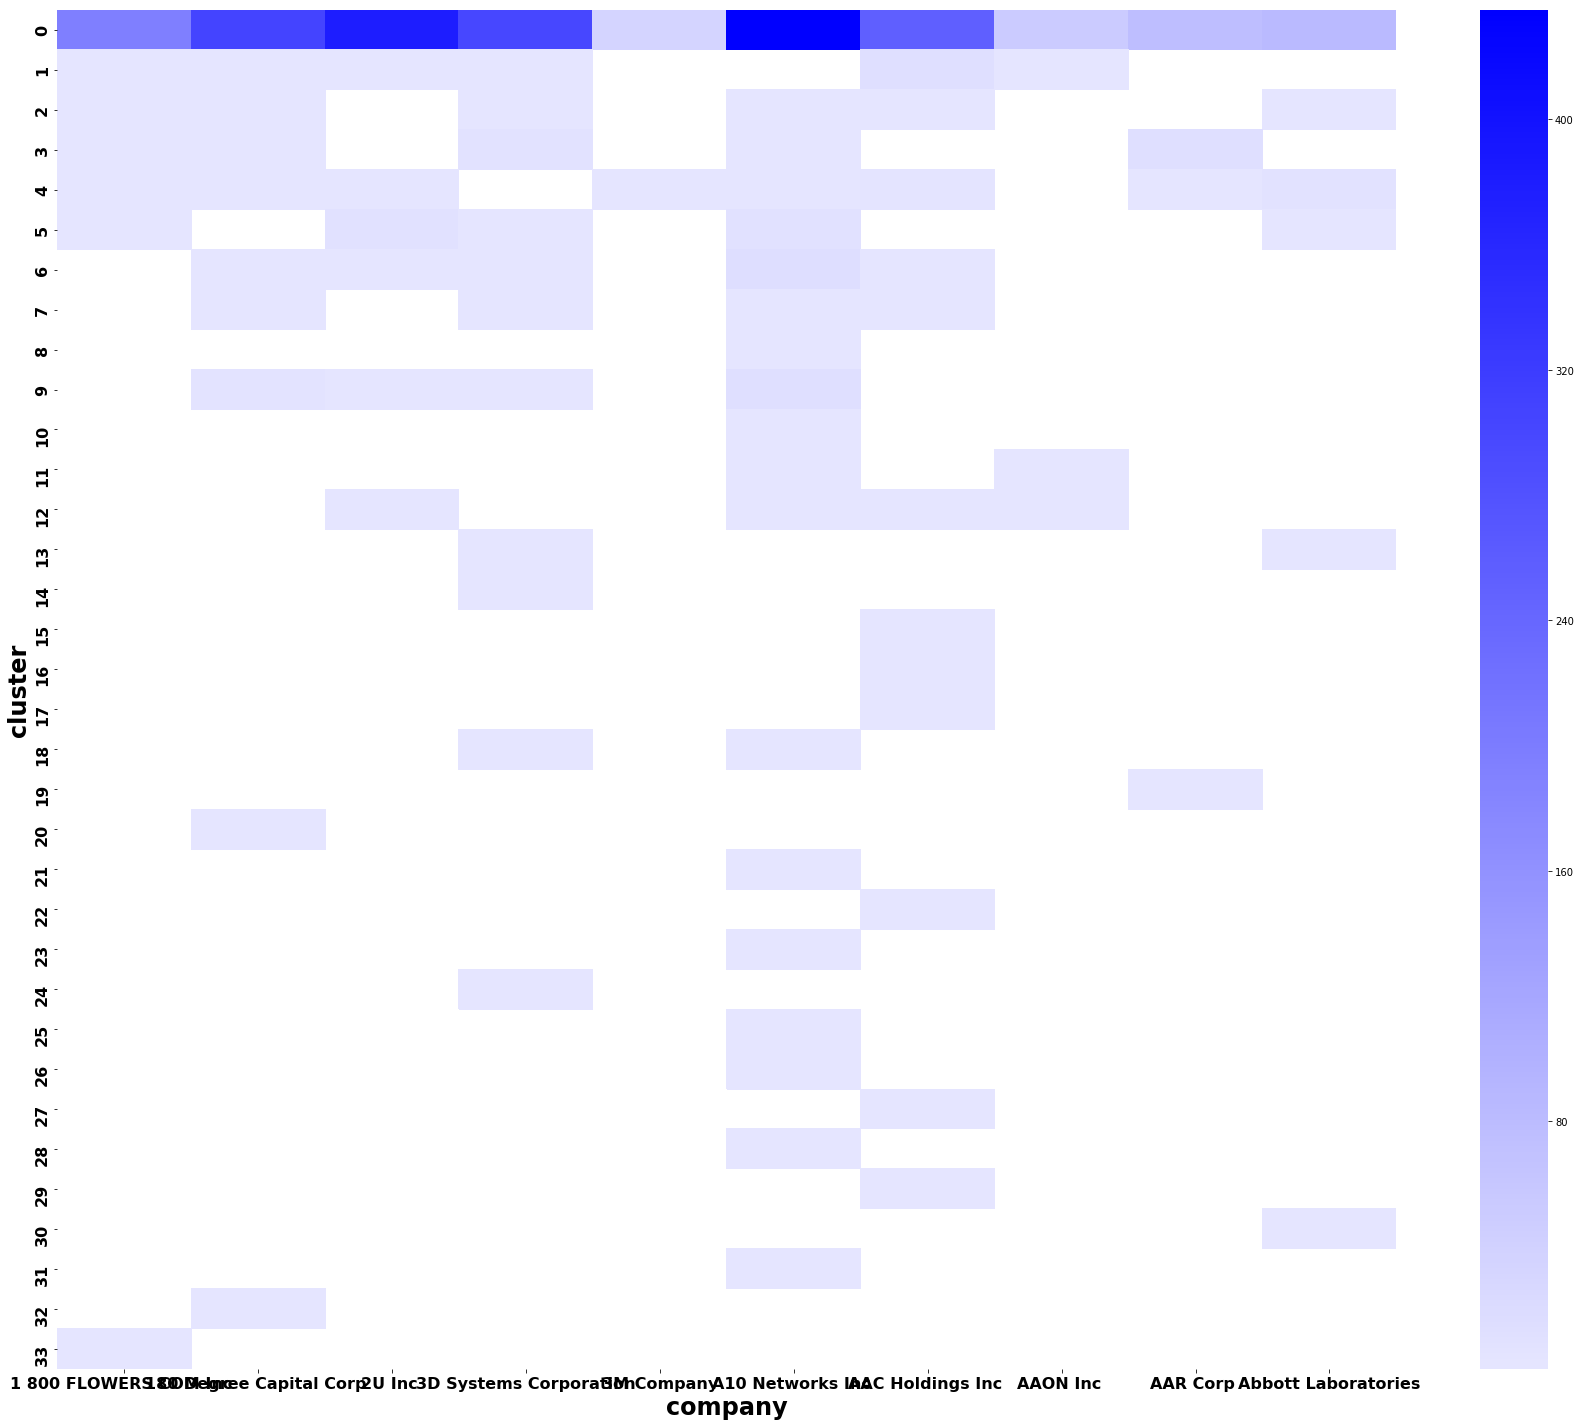

In [221]:
fig2, ax2 = plt.subplots(figsize = (30, 25))
cmap = sns.light_palette('blue', as_cmap=True)

sns.heatmap(company_clusters, ax = ax2, cmap = cmap)

ax2.set_xlabel('company', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

In [222]:
# SUMMARIZATION OF CORPORATE RISK FACTOR DISCLOSURE THROUGH TOPIC MODELING by Bao, Datta
strings = [
'Topic 0: investment, property, distribution, interest, agreement Shareholder’s interest risk',
'Topic 1: regulation, change, law, financial, operation, tax, accounting *Regulation changes(accounting)',
'Topic 2: gas, price, oil, natural, operation, production Input prices risks ',
'Topic 3: stock, price, share, market, future, dividend, security, stakeholder ** Stakeholder’s profit',
'Topic 4: cost, regulation, environmental, law, operation, liability *Regulation changes(environment) ',
'Topic 5: control, financial, internal, loss, reporting, history Financial condition risks ',
'Topic 6: financial, litigation, operation, condition, action, legal, liability, regulatory, claim, lawsuit *Potential/Ongoing Lawsuits',
'Topic 7: competitive, industry, competition, highly, market Competition risks' ,
'Topic 8: cost, operation, labor, operating, employee, increase, acquisition **Labor cost ',
'Topic 9: product, candidate, development, approval, clinical, regulatory New product introduction risks ',
'Topic 10: tax, income, asset, net, goodwill, loss, distribution, impairment, intangible **Accounting,  +Restructuring risks ',
'Topic 11: interest, director, officer, trust, combination, share, conflict **Management',
'Topic 12: product, liability, claim, market, insurance, sale, revenue Potential defects in products' ,
'Topic 13: loan, real, estate, investment, property, market, loss, portfolio **Investment' ,
'Topic 14: personnel, key, retain, attract, management, employee Human resource risks' ,
'Topic 15: stock, price, operating, stockholder, fluctuate, interest, volatile Volatile stock price risks ',
'Topic 16: acquisition, growth, future, operation, additional, capital, strategy Merger & Acquisition risks ',
'Topic 17: condition, economic, financial, market, industry, change, affected, downturn, demand Macroeconomic risks, +Industry is cyclical ',
'Topic 18: system, service, information, failure, product, operation, software, network, breach, interruption Disruption of operations, +Infrastructure risks ',
'Topic 19: cost, contract, operation, plan, increase, pension, delay **Postpone ',
'Topic 20: customer, product, revenue, sale, supplier, relationship, key, portion, contract, manufacturing, rely Rely on few large customers, +Suppliers risks +Downstream risks', 
'Topic 21: property, intellectual, protect, proprietary, technology, patent, protection, harm, license Intellectual property risks, +Licensing related risks' ,
'Topic 22: product, market, service, change, sale, demand, successfully, technology, competition Volatile demand and results, + Competition risks ',
'Topic 23: provision, law, control, change, stock, prevent, stockholder, Delaware, charter, delay, bylaw *Potential/Ongoing Lawsuits' ,
'Topic 24: regulation, government, change, revenue, contract, law, service *Regulation changes ',
'Topic 25: capital, credit, financial, market, cost, operation, rating, access, liquidity, downgrade **Credit risks ',
'Topic 26: debt, indebtedness, cash, obligation, financial, credit, covenant Funding risks ',
'Topic 27: operation, international, foreign, currency, rate, fluctuation International risks ',
'Topic 28: loss, insurance, financial, loan, reserve, operation, cover **Insurance' ,
'Topic 29: operation, natural, facility, disaster, event, terrorist, weather Catastrophes']
topics = [topic.split(":")[1] for topic in strings]


In [223]:
for topic in topics:
    print(topic)
    predict(topic)

 investment, property, distribution, interest, agreement Shareholder’s interest risk
Input String:  investment, property, distribution, interest, agreement Shareholder’s interest risk


Prediction
kmeans prediction: [0]
 results operations financial condition
 effect business financial
 regulation, change, law, financial, operation, tax, accounting *Regulation changes(accounting)
Input String:  regulation, change, law, financial, operation, tax, accounting *Regulation changes(accounting)


Prediction
kmeans prediction: [0]
 results operations financial condition
 effect business financial
 gas, price, oil, natural, operation, production Input prices risks 
Input String:  gas, price, oil, natural, operation, production Input prices risks 


Prediction
kmeans prediction: [0]
 results operations financial condition
 effect business financial
 stock, price, share, market, future, dividend, security, stakeholder ** Stakeholder’s profit
Input String:  stock, price, share, market, future, div

Input String:  capital, credit, financial, market, cost, operation, rating, access, liquidity, downgrade **Credit risks 


Prediction
kmeans prediction: [0]
 results operations financial condition
 effect business financial
 debt, indebtedness, cash, obligation, financial, credit, covenant Funding risks 
Input String:  debt, indebtedness, cash, obligation, financial, credit, covenant Funding risks 


Prediction
kmeans prediction: [0]
 results operations financial condition
 effect business financial
 operation, international, foreign, currency, rate, fluctuation International risks 
Input String:  operation, international, foreign, currency, rate, fluctuation International risks 


Prediction
kmeans prediction: [0]
 results operations financial condition
 effect business financial
 loss, insurance, financial, loan, reserve, operation, cover **Insurance
Input String:  loss, insurance, financial, loan, reserve, operation, cover **Insurance


Prediction
kmeans prediction: [0]
 results ope

In [260]:


def computeTF(document_text):
    wordset = get_tokens(document_text)
    print(wordset)
    word_dict = get_wordDict(wordset[0])
    tfDict = {}
    word_count = len(wordset)
    for word, count in word_dict.items():
        tfDict[word] = count/float(word_count)
    return tfDict

In [261]:
def get_wordDict(wordSet):
    wordDict = dict.fromkeys(wordSet, 0) 
    for doc in wordSet:   
        for word in doc:
            wordDict[word]+=1

    return wordDict

In [266]:
term_freqs = []
# for i  in range(len(doclist)):
# #     print(i)""
term_frequency = computeTF(doclist)
term_freqs.append(term_frequency)

[['[1] "Item 1A.', 'Risk Factors..', 'Investing in our common stock involves significant risks relating to our business and investment objectives.', 'You should carefully consider the risks and uncertainties described below before you purchase any shares of our common stock.', 'These risks and uncertainties are not the only ones we face.', 'Unknown additional risks and uncertainties, or ones that we currently consider immaterial, may also impact our business.', 'If any of these risks or uncertainties materialize, our business, financial condition or results of operations could be materially adversely affected.', 'In this event, the trading price of our common stock could decline, and you could lose all or part of your investment.. Risks related to our proposed change from a BDC to a registered closed-end fund..', "If shareholders approve the proposal to authorize the Board of Directors to withdraw the Company's election to be regulated as a BDC, the withdrawal will become effective upo

KeyError: '['

In [264]:
term_freqs

[{'[': 3.860258637328701e-05}]

In [253]:
def computeIDF(docList):
    idfDict = {}
    N = len(docList)
    big_wordset = []
    for doc in docList:
        big_wordset += get_tokens(doc)
    big_wordDict = get_wordDict(big_wordset)
        
    idfDict = dict.fromkeys(big_wordDict.keys(), 0)
  
    for word, val in big_wordDict.items():
        if val > 0:
            idfDict[word] += 1

    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))
        
    return idfDict

In [243]:
idfs = computeIDF(doclist)
idfs

TypeError: unhashable type: 'list'

In [238]:
def computeTFIDF(term_frequency, idfs):
    tfidf = {}
    for word, val in term_frequency.items():
        tfidf[word] = val*idfs[word]
    return tfidf

In [239]:
tfidfBow = computeTFIDF(term_frequency, idfs)


NameError: name 'idfs' is not defined

In [240]:
tfidfBow


NameError: name 'tfidfBow' is not defined

In [ ]:
# from https://stackoverflow.com/questions/4743035/obtaining-the-least-common-element-in-array
def least_common_values(array, to_find=None):
    counter = collections.Counter(array)
    if to_find is None:
        return sorted(counter.items(), key=itemgetter(1), reverse=False)
    return heapq.nsmallest(to_find, counter.items(), key=itemgetter(1))
least_common_values(tfidfBow, 20)

In [ ]:
collections.Counter(tfidfBow).most_common(20)


In [ ]:
collections.Counter(term_frequency).most_common(20)



In [231]:
# Latent Dirichlet Allocation
# Ref http://brandonrose.org/clustering
# LDA is a probabilistic topic model that assumes documents
# are a mixture of topics and that each word in the document is attributable to the document's topics.
from nltk.stem.snowball import SnowballStemmer
import re
stemmer = SnowballStemmer("english")
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

input_texts = doclist

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns
from gensim import corpora, models, similarities 

#remove proper names0
%time preprocess = [strip_proppers(doc) for doc in input_texts]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]
# print(texts)
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)
# print(dictionary)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.1)  
# THIS FILTERS EVERYTHING OUT
print(dictionary)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]
# print(corpus)
%time tfidf= models.TfidfModel(corpus, id2word=dictionary)
%time c = models.LdaModel(corpus, num_topics=30, id2word=dictionary, update_every=5, chunksize=10000, passes=100)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xanen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Wall time: 797 ms
Wall time: 1.47 s
Wall time: 127 ms
Dictionary(1212 unique tokens: ['absent', 'adverse..', 'adviser..', 'agnost', 'alongsid']...)
Wall time: 3.99 ms
Wall time: 1.58 s


In [234]:
from gensim import similarities

index_tffidf = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=12)
index_lda = similarities.SparseMatrixSimilarity(lda[corpus], num_features=12)

In [ ]:
topics_matrix = lda.show_topics(formatted=False, num_words=15)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word[0]) for word in i])
    print()

In [236]:
sims = index[tfidf[sparseMatrix]]
print(list(enumerate(sims)))

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing
lsi = models.lsimodel.LsiModel(corpus, num_topics=5, id2word=dictionary, chunksize=1000)
topics_matrix = lsi.show_topics(formatted=False, num_words=15)
topics_matrix = np.array(topics_matrix)
topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word[0]) for word in i])
    print()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X[0])
print()
print(dist)

In [ ]:
words = ['investment', 'property', 'distribution', 'interest', 'agreement']
# tag = Shareholder’s interest risk 
predict('cost, regulation, environmental, law, operation, liability')
predict('loss, insurance, financial, loan, reserve, operation, cover **Insurance ')
predict('operation, natural, facility, disaster, event, terrorist, weather Catastrophes')